In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class Station:
    def __init__(self, station_id, name, latitude, longitude, rental_count=0):
        """Station 객체가 생성될 때 속성을 초기화합니다."""
        self.station_id = station_id
        self.name = name
        self.latitude = latitude
        self.longitude = longitude
        self.rental_count = int(rental_count) # 대여횟수는 정수형으로 저장

    def __repr__(self):
        """객체를 print() 함수로 출력할 때 보여줄 형식을 정의합니다."""
        return (f"Station(ID: {self.station_id}, 이름: '{self.name}', "
                f"위도: {self.latitude}, 경도: {self.longitude}, "
                f"3년간 총 대여횟수: {self.rental_count:,})")


# ----------------------------------------------------
# 2단계: 데이터 준비 및 통합
# ----------------------------------------------------
# 파일 경로를 실제 환경에 맞게 수정해주세요.
# 예: '/content/drive/MyDrive/data/대여소좌표정보.csv'
info_file_path = '/content/drive/MyDrive/endgame/대여소좌표정보.csv'
count_file_path = '/content/drive/MyDrive/endgame/대여소대여정보.csv'

try:
    # --- 데이터 소스 A: 대여소 기본 정보 읽기 ---
    # 사용하셨던 코드를 기반으로 컬럼명을 명확히 하여 읽어옵니다.
    stations_info_df = pd.read_csv(info_file_path, skiprows=3, header=None, encoding='utf-8')
    stations_info_df.columns = ['대여소 번호', '보관소(대여소)명', '자치구', '상세주소', '위도', '경도']
    # 필요한 컬럼만 선택
    stations_info_df = stations_info_df[['대여소 번호', '보관소(대여소)명', '위도', '경도']]


    # --- 데이터 소스 B: 대여소별 총 대여 횟수 읽기 ---
    rental_counts_df = pd.read_csv(count_file_path) # 이 파일은 헤더가 있으므로 skiprows 불필요

    # --- 두 데이터 통합 (Merge) ---
    # '대여소 번호'와 '대여소 아이디'를 기준으로 두 데이터를 합칩니다. (left join)
    merged_df = pd.merge(
        stations_info_df,
        rental_counts_df,
        left_on='대여소 번호',
        right_on='대여소 아이디',
        how='left' # 좌표 정보는 있지만 대여 기록은 없는 대여소도 포함하기 위해 'left' 사용
    )

    # 대여 기록이 없는 대여소의 'total' 값은 NaN이 되므로, 0으로 채워줍니다.
    merged_df['total'] = merged_df['total'].fillna(0)

    # ----------------------------------------------------
    # 3단계: 통합된 데이터로 Station 객체 생성 및 딕셔너리에 저장
    # ----------------------------------------------------
    stations_dict = {} # 대여소 객체들을 저장할 빈 딕셔너리

    # merged_df의 한 행씩 반복하면서 Station 객체 생성
    for index, row in merged_df.iterrows():
        station_id = row['대여소 번호']

        # Station 클래스를 이용해 객체 인스턴스 생성
        station_object = Station(
            station_id=station_id,
            name=row['보관소(대여소)명'],
            latitude=row['위도'],
            longitude=row['경도'],
            rental_count=row['total']
        )

        # 딕셔너리에 '대여소 번호'를 키(key)로, 생성된 객체를 값(value)으로 저장
        stations_dict[station_id] = station_object

    print(f"--- 총 {len(stations_dict)}개의 대여소 객체 생성이 완료되었습니다. ---")

    # --- 결과 확인 ---
    print("\n[예시] 대여소 번호 2715번 객체 정보:")
    if 2715 in stations_dict:
        print(stations_dict[2715])
    else:
        print("2715번 대여소 정보를 찾을 수 없습니다.")

    print("\n[예시] 대여소 번호 502번 객체 정보:")
    if 502 in stations_dict:
        print(stations_dict[502])
    else:
        print("502번 대여소 정보를 찾을 수 없습니다.")


except FileNotFoundError as e:
    print(f"오류: 파일을 찾을 수 없습니다. 파일 경로를 다시 확인해주세요.\n({e})")
except Exception as e:
    print(f"데이터 처리 중 오류가 발생했습니다: {e}")

--- 총 2760개의 대여소 객체 생성이 완료되었습니다. ---

[예시] 대여소 번호 2715번 객체 정보:
Station(ID: 2715, 이름: '마곡나루역 2번 출구', 위도: 37.5669, 경도: 126.827, 3년간 총 대여횟수: 242,858)

[예시] 대여소 번호 502번 객체 정보:
Station(ID: 502, 이름: '뚝섬유원지역 1번출구 앞', 위도: 37.5319, 경도: 127.067, 3년간 총 대여횟수: 225,907)


In [5]:
import pandas as pd # pandas가 import 되어 있어야 NaN 값 확인 가능

# 이전 단계에서 stations_dict 가 성공적으로 생성되었다고 가정합니다.
# 만약 이전 코드를 실행하지 않았다면, 이 코드 실행 전에 먼저 실행해야 합니다.

print(f"--- 데이터 유효성 검사를 시작합니다. (원본 데이터: {len(stations_dict)}개) ---")

# 유효한 대여소 객체만 담을 새로운 딕셔너리
valid_stations_dict = {}
# 어떤 데이터가 왜 삭제되었는지 기록할 리스트
removed_log = []

# 전체 딕셔너리를 순회하며 유효성 검사 수행
for station_id, station in stations_dict.items():
    # 1. 유효성 검사 조건 설정
    is_valid = True
    reason = []

    # 조건 1: 대여 횟수가 0보다 커야 함
    if station.rental_count <= 0:
        is_valid = False
        reason.append("대여 기록 없음")

    # 조건 2: 위도, 경도 값이 유효해야 함 (NaN이 아니어야 함)
    if pd.isna(station.latitude) or pd.isna(station.longitude):
        is_valid = False
        reason.append("좌표 정보 없음")

    # 조건 3: 대여소 이름이 있어야 함
    if not station.name or pd.isna(station.name):
        is_valid = False
        reason.append("대여소 이름 없음")


    # 2. 검사 결과에 따라 처리
    if is_valid:
        # 모든 조건을 통과한 유효한 객체만 새로운 딕셔너리에 추가
        valid_stations_dict[station_id] = station
    else:
        # 유효하지 않은 경우, 왜 삭제되었는지 로그에 기록
        removed_log.append(f"ID: {station_id}, 이름: '{station.name}', 삭제 사유: {', '.join(reason)}")


# --- 최종 결과 출력 ---
print("\n--- 유효성 검사 완료 ---")
print(f"원본 데이터 수: {len(stations_dict)}개")
print(f"삭제된 데이터 수: {len(removed_log)}개")
print(f"최종 유효 데이터 수: {len(valid_stations_dict)}개")

# 삭제된 데이터 중 일부를 예시로 출력 (최대 5개)
if removed_log:
    print("\n[삭제된 데이터 예시]")
    for log_entry in removed_log[:5]:
        print(log_entry)

# 이제부터 분석에는 `valid_stations_dict`를 사용하시면 됩니다.
# 예시로 정제된 딕셔너리의 객체 하나를 출력
if valid_stations_dict:
    # 딕셔너리에서 첫 번째 아이템을 가져와서 출력
    first_key = next(iter(valid_stations_dict))
    print("\n[정제된 데이터 예시]")
    print(valid_stations_dict[first_key])

--- 데이터 유효성 검사를 시작합니다. (원본 데이터: 2760개) ---

--- 유효성 검사 완료 ---
원본 데이터 수: 2760개
삭제된 데이터 수: 6개
최종 유효 데이터 수: 2754개

[삭제된 데이터 예시]
ID: 4394, 이름: '서울시립24시간게스트하우스', 삭제 사유: 대여 기록 없음
ID: 5330, 이름: '구립수락노인복지관', 삭제 사유: 대여 기록 없음
ID: 5329, 이름: '상계주공15단지 1509동 앞', 삭제 사유: 대여 기록 없음
ID: 4693, 이름: '수색감리교회', 삭제 사유: 대여 기록 없음
ID: 6172, 이름: '가양5단지아파트', 삭제 사유: 대여 기록 없음

[정제된 데이터 예시]
Station(ID: 303, 이름: '광화문역 1번출구 앞', 위도: 37.5718, 경도: 126.975, 3년간 총 대여횟수: 72,387)


In [7]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 53.0 MB/s eta 0:00:00


데이터 준비 완료. 시각화를 시작합니다.


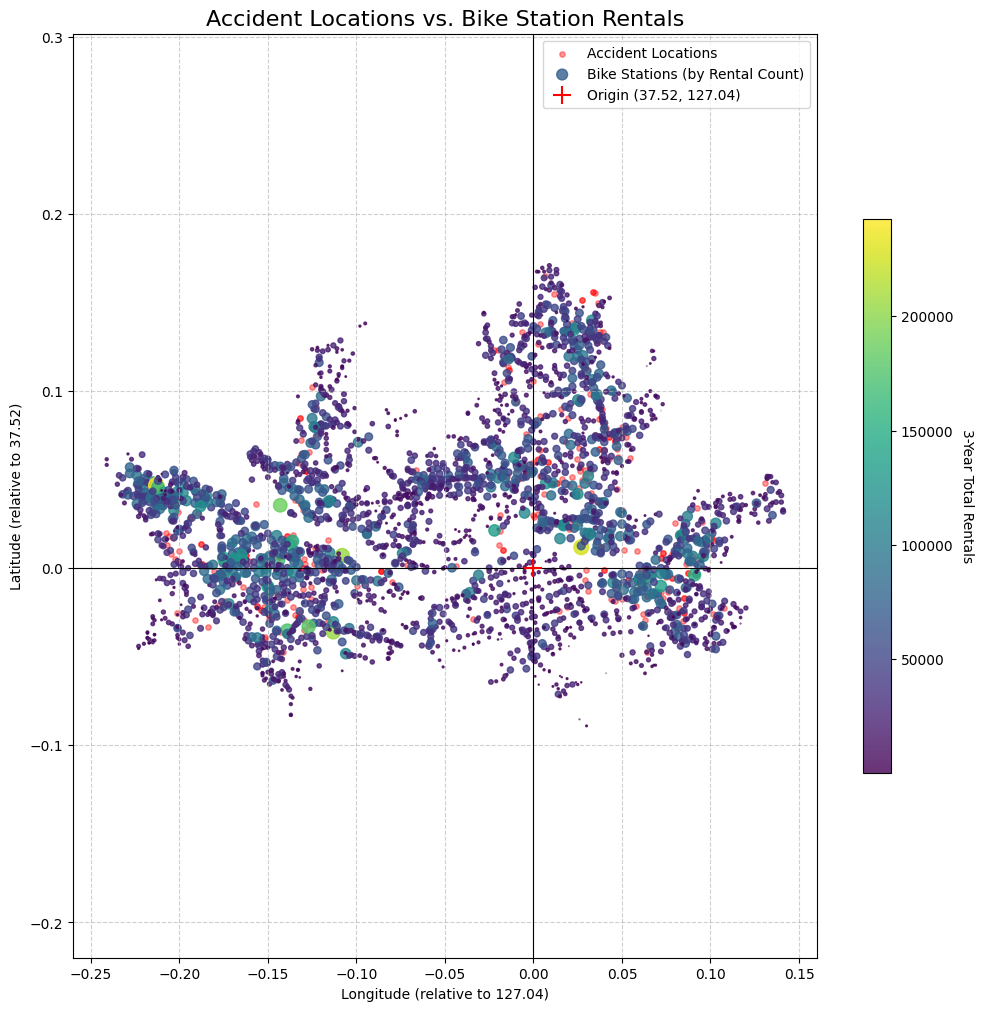

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 0단계, 1단계, 2단계: 데이터 준비 및 좌표 변환 (이전과 동일)
# ----------------------------------------------------

# (가정) accident_df 와 station_df 가 이미 로드 및 생성되어 있다고 가정합니다.
# 이 코드를 실행하기 전에 데이터 로드 및 변환 코드가 먼저 실행되어야 합니다.
print("데이터 준비 완료. 시각화를 시작합니다.")


# ----------------------------------------------------
# 3단계: 두 데이터 통합 시각화 (수정됨)
# ----------------------------------------------------
plt.figure(figsize=(12, 12))

# ==========================================================
# ▼▼▼▼▼▼▼▼▼▼▼▼▼▼ 이 부분을 수정했습니다 ▼▼▼▼▼▼▼▼▼▼▼▼▼▼
# ==========================================================
# 1. '사고 데이터' 그리기 (가시성 개선)
if not accident_df.empty:
    plt.scatter(
        accident_df['x'],
        accident_df['y'],
        alpha=0.4,       # (수정) 투명도를 약간 높여 더 잘 보이게
        s=15,            # (수정) 점 크기를 약간 키움
        color='red',     # (수정) 색상을 눈에 띄는 'red'로 변경
        label='Accident Locations'
    )
# ==========================================================
# ▲▲▲▲▲▲▲▲▲▲▲▲▲▲ 수정 완료 ▲▲▲▲▲▲▲▲▲▲▲▲▲▲
# ==========================================================

# 2. 핵심 데이터인 '따릉이 대여소' 그리기 (변경 없음)
scatter = plt.scatter(
    station_df['x'],
    station_df['y'],
    s=station_df['rental_count'] / 2000,
    c=station_df['rental_count'],
    cmap='viridis',
    alpha=0.8,
    label='Bike Stations (by Rental Count)'
)

# 3. 원점 표시 (가장 위 레이어에)
plt.scatter(0, 0, color='red', marker='+', s=150, zorder=5, label=f'Origin (37.52, 127.04)')


# --- 그래프 디자인 및 레이블 설정 (변경 없음) ---
plt.title('Accident Locations vs. Bike Station Rentals', fontsize=16)
plt.xlabel(f'Longitude (relative to {origin_lon})')
plt.ylabel(f'Latitude (relative to {origin_lat})')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='black', linewidth=0.8)
plt.axvline(0, color='black', linewidth=0.8)
plt.axis('equal')

# 범례(legend)와 컬러바(colorbar) 추가
plt.legend()
cbar = plt.colorbar(scatter, shrink=0.6)
cbar.set_label('3-Year Total Rentals', rotation=270, labelpad=15)

plt.show()

데이터 준비 완료. 시각화를 시작합니다.


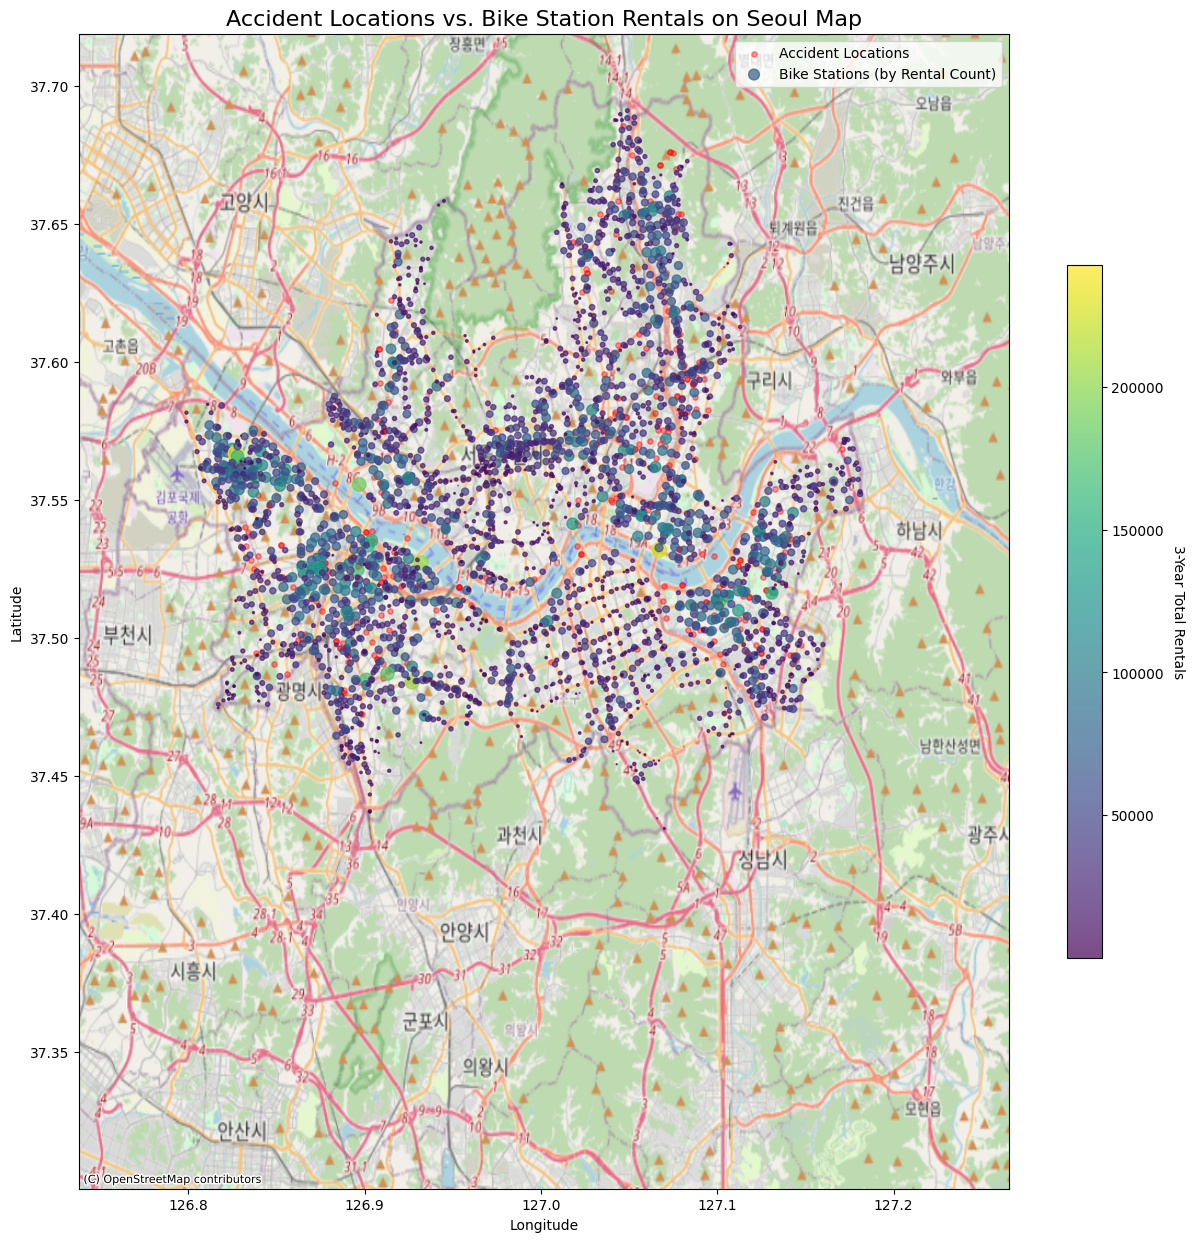

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx # contextily 라이브러리 import

# ----------------------------------------------------
# 0단계: 데이터 준비 (이전 코드와 동일)
# ----------------------------------------------------
# (가정) accident_df 와 station_df 가 이미 로드 및 생성되어 있다고 가정합니다.
# 만약 세션이 재시작되었다면, 이전 코드를 먼저 실행하여 두 데이터프레임을 생성해주세요.
# assert 'accident_df' in locals() and 'station_df' in locals(), "먼저 이전 스텝을 실행하여 데이터프레임을 생성해주세요."
print("데이터 준비 완료. 시각화를 시작합니다.")

# ----------------------------------------------------
# 1단계: 시각화 객체 생성
# ----------------------------------------------------
# contextily와 함께 사용하기 위해 fig, ax 객체를 명시적으로 생성합니다.
fig, ax = plt.subplots(figsize=(15, 15))

# ----------------------------------------------------
# 2단계: 데이터 플로팅 (상대좌표 x,y 대신 원본 위도,경도 사용)
# ----------------------------------------------------

if not accident_df.empty:
    ax.scatter(
        accident_df['longitude'],
        accident_df['latitude'],
        alpha=0.4,       # (수정) 투명도를 약간 높여 더 잘 보이게
        s=15,            # (수정) 점 크기를 약간 키움
        color='red',     # (수정) 색상을 눈에 띄는 'red'로 변경
        label='Accident Locations'
    )

# 2. 핵심 데이터인 '따릉이 대여소' 그리기 (변경 없음)
scatter = ax.scatter(
    station_df['longitude'],
    station_df['latitude'],
    s=station_df['rental_count'] / 2000,
    c=station_df['rental_count'],
    cmap='viridis',
    alpha=0.7,
    label='Bike Stations (by Rental Count)'
)

# ==========================================================
# ▲▲▲▲▲▲▲▲▲▲▲▲▲▲ 수정 완료 ▲▲▲▲▲▲▲▲▲▲▲▲▲▲
# ==========================================================


# 3단계: 지도 배경 추가 (변경 없음)
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik)


# 4단계: 그래프 디자인 및 레이블 설정 (변경 없음)
ax.set_title('Accident Locations vs. Bike Station Rentals on Seoul Map', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.autoscale(True)
ax.legend()
cbar = fig.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label('3-Year Total Rentals', rotation=270, labelpad=15)

plt.show()

In [12]:
!pip install haversine

In [13]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from haversine import haversine, Unit

# --- 0단계: 설정 및 준비 ---
# (가정) valid_stations_dict 와 accident_df 가 메모리에 존재해야 합니다.
# assert 'valid_stations_dict' in locals() and 'accident_df' in locals(), "먼저 이전 스텝을 실행하여 데이터프레임을 생성해주세요."

RADIUS_M = 250 # 반경을 250미터로 설정
print(f"--- 대여소 안전도 분류를 시작합니다. (분석 반경: {RADIUS_M}m) ---")


# --- 1단계: 각 대여소 반경 내 사고 건수 계산 ---
# 계산 속도를 높이기 위해 SciPy의 cKDTree를 사용합니다.

# 사고 데이터의 좌표를 (위도, 경도) 리스트로 준비
accident_coords = accident_df[['latitude', 'longitude']].values
# 대여소 데이터의 좌표를 (위도, 경도) 리스트로 준비
station_coords = np.array([[s.latitude, s.longitude] for s in valid_stations_dict.values()])

# 사고 위치에 대한 KDTree 생성
accident_tree = cKDTree(accident_coords)

# 대여소 위치를 기준으로 반경 내 사고 건수 검색
# 1 도(degree)는 약 111.139 km 이므로, 미터를 도로 변환
radius_in_degrees = RADIUS_M / 111139
# 각 대여소의 반경 내에 있는 사고 데이터 포인트의 인덱스 리스트를 찾음
indices = accident_tree.query_ball_point(station_coords, r=radius_in_degrees)

# 각 대여소 객체에 '주변 사고 건수' 속성 추가
# indices 리스트의 각 원소(리스트)의 길이를 세면, 그것이 바로 주변 사고 건수
for i, station in enumerate(valid_stations_dict.values()):
    station.nearby_accident_count = len(indices[i])

print("1단계: 각 대여소 주변 사고 건수 계산 완료.")


# --- 2단계: '위험 지수' 계산 ---
# 각 대여소 객체에 '위험 지수' 속성 추가
for station in valid_stations_dict.values():
    if station.rental_count > 0:
        risk_index = (station.nearby_accident_count / station.rental_count) * 10000
    else:
        risk_index = 0 # 대여 기록이 없으면 위험도 0
    station.risk_index = risk_index

print("2단계: 각 대여소별 '위험 지수' 계산 완료.")


# --- 3단계: 분류 기준 설정 및 Classification ---
# 모든 대여소의 위험 지수 값을 리스트로 추출
all_risk_indices = [s.risk_index for s in valid_stations_dict.values()]

# 백분위(Percentile)를 사용하여 분류 기준값 계산
# np.nanpercentile을 사용하여 계산 중 발생할 수 있는 NaN 값을 무시
p20 = np.nanpercentile(all_risk_indices, 20) # 하위 20%
p80 = np.nanpercentile(all_risk_indices, 80) # 상위 20% (즉, 하위 80%)

print(f"3단계: 분류 기준값 계산 완료 (하위 20% 지수: {p20:.4f}, 상위 20% 지수: {p80:.4f})")

# 각 대여소 객체에 '안전도 등급' 속성 추가
for station in valid_stations_dict.values():
    if station.risk_index >= p80:
        station.safety_class = '위험'
    elif station.risk_index < p20:
        station.safety_class = '안전'
    else:
        station.safety_class = '보통'

print("--- 모든 대여소의 안전도 등급 분류 완료! ---")


# --- 최종 결과 확인 ---
print("\n[분류 결과 예시]")
safe_examples = []
normal_examples = []
danger_examples = []

for station in valid_stations_dict.values():
    if station.safety_class == '안전' and len(safe_examples) < 2:
        safe_examples.append(station)
    elif station.safety_class == '보통' and len(normal_examples) < 2:
        normal_examples.append(station)
    elif station.safety_class == '위험' and len(danger_examples) < 2:
        danger_examples.append(station)

print("\n--- '안전' 등급 대여소 ---")
for s in safe_examples:
    print(f"ID: {s.station_id}, 이름: {s.name}, 위험지수: {s.risk_index:.4f}, 대여수: {s.rental_count}, 주변사고수: {s.nearby_accident_count}")

print("\n--- '보통' 등급 대여소 ---")
for s in normal_examples:
    print(f"ID: {s.station_id}, 이름: {s.name}, 위험지수: {s.risk_index:.4f}, 대여수: {s.rental_count}, 주변사고수: {s.nearby_accident_count}")

print("\n--- '위험' 등급 대여소 ---")
for s in danger_examples:
    print(f"ID: {s.station_id}, 이름: {s.name}, 위험지수: {s.risk_index:.4f}, 대여수: {s.rental_count}, 주변사고수: {s.nearby_accident_count}")

--- 대여소 안전도 분류를 시작합니다. (분석 반경: 250m) ---
1단계: 각 대여소 주변 사고 건수 계산 완료.
2단계: 각 대여소별 '위험 지수' 계산 완료.
3단계: 분류 기준값 계산 완료 (하위 20% 지수: 0.0000, 상위 20% 지수: 0.0000)
--- 모든 대여소의 안전도 등급 분류 완료! ---

[분류 결과 예시]

--- '안전' 등급 대여소 ---

--- '보통' 등급 대여소 ---

--- '위험' 등급 대여소 ---
ID: 303, 이름: 광화문역 1번출구 앞, 위험지수: 0.0000, 대여수: 72387, 주변사고수: 0
ID: 305, 이름: 종로구청 옆, 위험지수: 0.0000, 대여수: 53278, 주변사고수: 0


--- Starting Station Safety Classification. (Analysis Radius: 500m) ---
New classification thresholds (Bottom 20%: 0.0000, Top 20%: 0.3154)
--- Safety class re-classification complete! ---

'station_safety_classification.csv' file has been saved successfully.


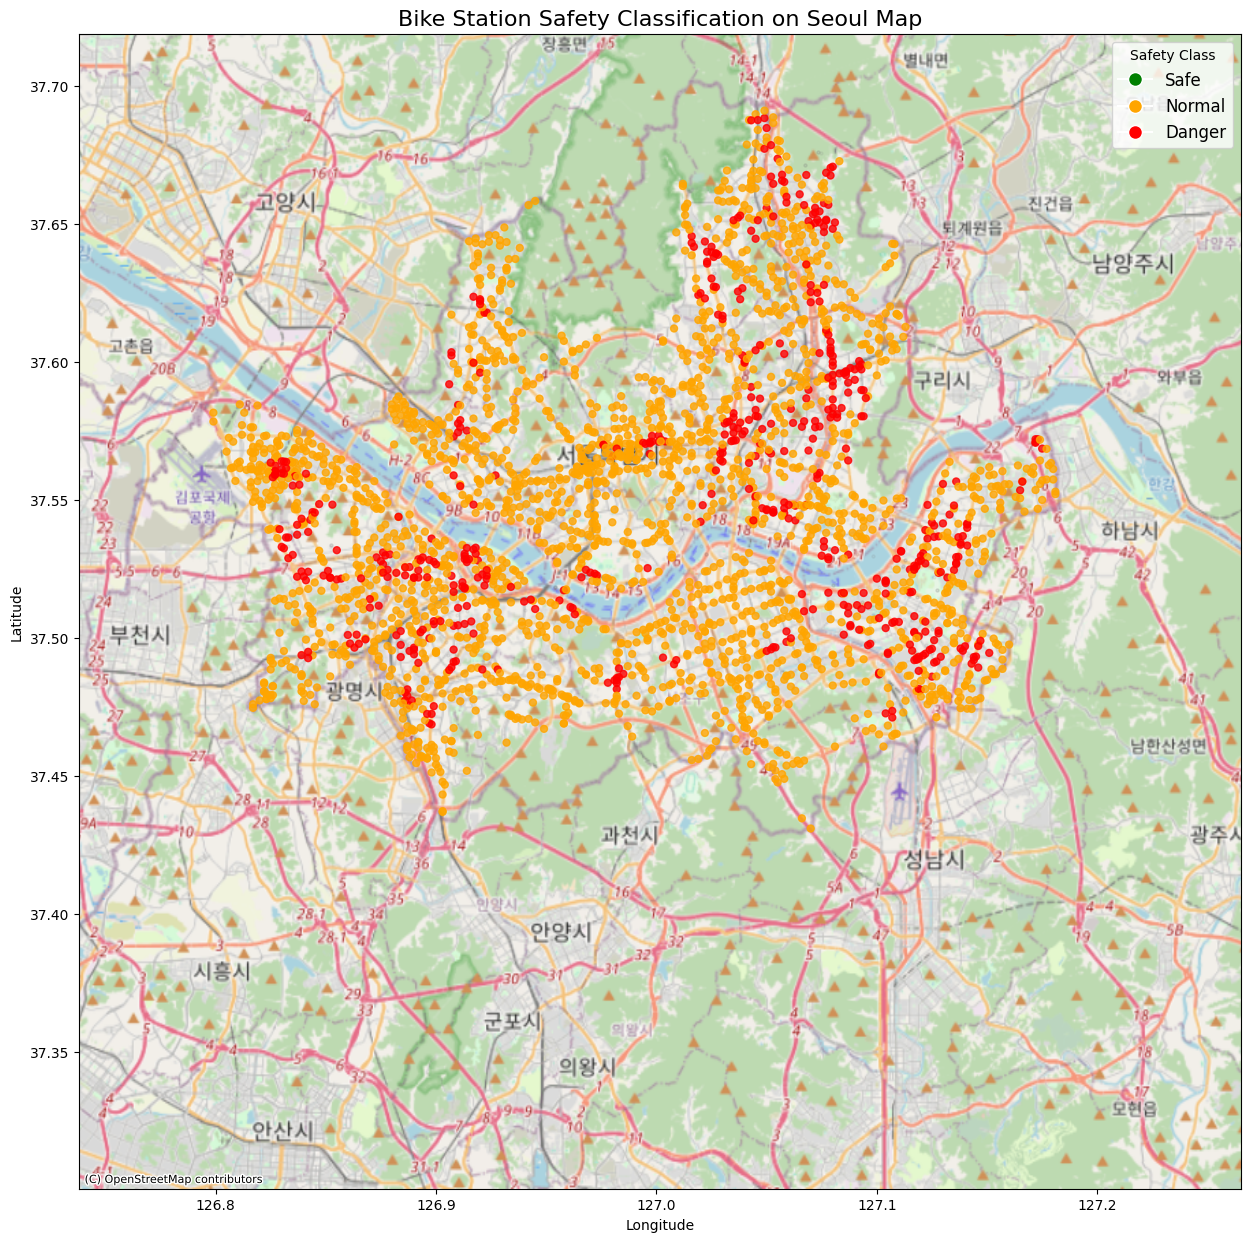

In [15]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import contextily as ctx

# (가정) valid_stations_dict 와 accident_df 가 메모리에 존재해야 합니다.

# --- 0단계: 설정 및 준비 ---
RADIUS_M = 500
# (Changed) Print statements changed to English
print(f"--- Starting Station Safety Classification. (Analysis Radius: {RADIUS_M}m) ---")


# --- 1단계, 2단계: 분류 로직 (이전과 동일) ---
accident_coords = accident_df[['latitude', 'longitude']].values
station_coords = np.array([[s.latitude, s.longitude] for s in valid_stations_dict.values()])
accident_tree = cKDTree(accident_coords)
radius_in_degrees = RADIUS_M / 111139
indices = accident_tree.query_ball_point(station_coords, r=radius_in_degrees)

for i, station in enumerate(valid_stations_dict.values()):
    station.nearby_accident_count = len(indices[i])

for station in valid_stations_dict.values():
    if station.rental_count > 0:
        station.risk_index = (station.nearby_accident_count / station.rental_count) * 10000
    else:
        station.risk_index = 0

# --- 3단계: 분류 기준 설정 및 Classification (수정됨) ---
all_risk_indices = [s.risk_index for s in valid_stations_dict.values()]
p20 = np.nanpercentile(all_risk_indices, 20)
p80 = np.nanpercentile(all_risk_indices, 80)
# (Changed) Print statements changed to English
print(f"New classification thresholds (Bottom 20%: {p20:.4f}, Top 20%: {p80:.4f})")

# (Changed) Classification values changed to English
for station in valid_stations_dict.values():
    if station.risk_index >= p80 and station.risk_index > 0:
        station.safety_class = 'Danger'
    elif station.risk_index < p20:
        station.safety_class = 'Safe'
    else:
        station.safety_class = 'Normal'
# (Changed) Print statements changed to English
print("--- Safety class re-classification complete! ---")


# --- 4단계: 결과 저장 및 시각화 (수정됨) ---

# --- 4-1. 분류 결과를 CSV 파일로 저장 ---
final_station_list = [
    {
        'station_id': s.station_id,
        'name': s.name,
        'latitude': s.latitude,
        'longitude': s.longitude,
        'total_rentals': s.rental_count,
        'nearby_accidents': s.nearby_accident_count,
        'risk_index': s.risk_index,
        'safety_class': s.safety_class
    }
    for s in valid_stations_dict.values()
]
final_df = pd.DataFrame(final_station_list)

# (Changed) Filename changed to English
output_filename = 'station_safety_classification.csv'
final_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
# (Changed) Print statements changed to English
print(f"\n'{output_filename}' file has been saved successfully.")


# --- 4-2. 안전도 등급을 지도에 시각화 ---

# (Changed) Color map keys changed to English
color_map = {
    'Danger': 'red',
    'Normal': 'orange',
    'Safe': 'green'
}
final_df['color'] = final_df['safety_class'].map(color_map)

# 시각화 객체 생성
fig, ax = plt.subplots(figsize=(15, 15))

# 배경으로 사고 데이터 그리기
if not accident_df.empty:
    ax.scatter(accident_df['longitude'], accident_df['latitude'], alpha=0.1, s=5, color='gray', label='Accident Locations')

# 안전도 등급에 따라 색상이 지정된 대여소 그리기
ax.scatter(
    final_df['longitude'],
    final_df['latitude'],
    color=final_df['color'],
    s=25,
    alpha=0.8
)

# 지도 배경 추가
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik)

# 그래프 디자인 및 범례 추가
ax.set_title('Bike Station Safety Classification on Seoul Map', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.autoscale(True)

# (Changed) Legend elements changed to English
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Safe', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='orange', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Danger', markerfacecolor='red', markersize=10)
]
ax.legend(handles=legend_elements, title="Safety Class", fontsize=12)

plt.show()